In [5]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN
from keras.callbacks import ModelCheckpoint
from random import randint
from matplotlib import pyplot as pl

In [6]:
with open("sonnets.txt") as corpus_file:
    corpus = corpus_file.read()
    corpus_length = len(corpus)
print("Loaded a corpus of {0} characters".format(corpus_length))

Loaded a corpus of 94651 characters


In [7]:
# Get a unique identifier for each char in the corpus, 
# then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

Our corpus contains 61 unique characters.


In [8]:
# chop up our data into X and y, slice into roughly 
# (num_chars / skip) overlapping 'sentences' of length 
# sentence_length, and encode the chars
sentence_length = 20
skip = 1
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))

Sliced our corpus into 94631 sentences of length 20


In [9]:
print(X_data[1])

[52, 49, 47, 1, 40, 35, 43, 52, 39, 53, 54, 1, 37, 52, 39, 35, 54, 55, 52, 39]


In [10]:
print([decoding[idx] for idx in X_data[1]])
print(decoding[y_data[1]])

['r', 'o', 'm', ' ', 'f', 'a', 'i', 'r', 'e', 's', 't', ' ', 'c', 'r', 'e', 'a', 't', 'u', 'r', 'e']
s


In [11]:
# Vectorize our data and labels. We want everything in one-hot.
print("Vectorizing X and y...")
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=np.bool)
y = np.zeros((num_sentences, num_chars), dtype=np.bool)
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
    y[i, y_data[i]] = 1

Vectorizing X and y...


In [12]:
# Double check our vectorized data before we sink hours into fitting a model
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}"
      .format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}"
      .format(X.shape, sentence_length))

Sanity check y. Dimension: (94631, 61) # Sentences: 94631 Characters in corpus: 61
Sanity check X. Dimension: (94631, 20, 61) Sentence length: 20


In [13]:
# Define our model
model = Sequential()
model.add(SimpleRNN(256, input_shape=(sentence_length, num_chars), 
                    return_sequences=False))
model.add(Dense(num_chars))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 256)               81408     
_________________________________________________________________
dense_1 (Dense)              (None, 61)                15677     
_________________________________________________________________
activation_1 (Activation)    (None, 61)                0         
Total params: 97,085
Trainable params: 97,085
Non-trainable params: 0
_________________________________________________________________


In [14]:
#training time
log = model.fit(X, y, epochs=50, batch_size=128)

Epoch 1/50
94631/94631 [==============================] - 30s 321us/step - loss: 2.5162 - acc: 0.3058
Epoch 2/50
94631/94631 [==============================] - 25s 268us/step - loss: 2.1761 - acc: 0.3694
Epoch 3/50
94631/94631 [==============================] - 25s 264us/step - loss: 2.0839 - acc: 0.3898
Epoch 4/50
94631/94631 [==============================] - 25s 267us/step - loss: 2.0118 - acc: 0.4076
Epoch 5/50
94631/94631 [==============================] - 25s 267us/step - loss: 1.9512 - acc: 0.4212
Epoch 6/50
94631/94631 [==============================] - 25s 266us/step - loss: 1.8988 - acc: 0.4348
Epoch 7/50
94631/94631 [==============================] - 25s 266us/step - loss: 1.8508 - acc: 0.4448
Epoch 8/50
94631/94631 [==============================] - 25s 263us/step - loss: 1.8072 - acc: 0.4569
Epoch 9/50
94631/94631 [==============================] - 25s 266us/step - loss: 1.7650 - acc: 0.4678
Epoch 10/50
94631/94631 [==============================] - 29s 309us/step - loss: 

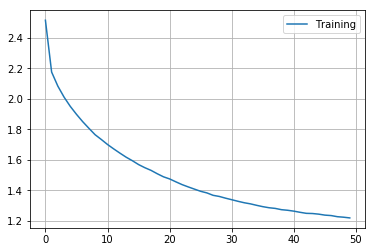

In [15]:
pl.plot(log.history['loss'], label='Training')
pl.legend()
pl.grid()

In [16]:
def make_seed(seed_phrase=""):
        if seed_phrase:
            phrase_length = len(seed_phrase)
            pattern = ""
            for i in range (0, sentence_length):
                pattern += seed_phrase[i % phrase_length]
        else:
            seed = randint(0, corpus_length - sentence_length)
            pattern = corpus[seed:seed + sentence_length]

        return pattern

In [17]:
seed_pattern = make_seed("In the early morning, the flower is shining")
print(seed_pattern)

In the early morning


In [18]:
X = np.zeros((1, sentence_length, num_chars), dtype=np.bool)
for i, character in enumerate(seed_pattern):
    X[0, i, encoding[character]] = 1

generated_text = ""
for i in range(500):
    output_prob = model.predict(X, verbose=0)[0]
    # alternative is to use argmax: prediction = np.argmax(output_prob)
    prediction = np.random.choice(num_chars, p = output_prob )
    generated_text += decoding[prediction]
    activations = np.zeros((1, 1, num_chars), dtype=np.bool)
    activations[0, 0, prediction] = 1
    #now remove first char and glue the predicted one
    X = np.concatenate((X[:, 1:, :], activations), axis=1)
print(generated_text)

 thee,
I will nefore agains thim,
Haw,
They tru--formortian the glatter child;
O! love look glow me love, be ntill pesse to all will, thy smeel'd bugger helfest'st upreefin your pleasures to the sun is of your wakers be muspieg;
When revery loving her every one more trans'd ever love sweet sold be fisgorn.

Then look in these chate;
When I wint as redeemsed;
Betorrow him her, whore good on ter the palfect, sumour dase, for when fron thee, that lood being thy shown their enrmsse for me of laving 
